# cosmo 

R.T. Marquez<br>
Available at https://github.com/rcmarq/cosmo

This jupyter notebook demonstrates the new functionalities added to the <a href='https://doi.org/10.1016/j.chemgeo.2009.05.010'>Double Spike Toolbox</a> from the `cosmo` software suite developed by <a href=''>Marquez and Tissot (2022)</a>. 

### Requirements
1. Running the Double Spike Toolbox per J.F. Rudge: MATLAB 7.1 (R14SP3) or higher with the Statistics and Optimization Toolboxes.
2. Running the `cosmo` software package: v.1.02 or later of the Double Spike Toolbox (see https://github.com/johnrudge/doublespike)
3. Running the demo ipynb notebook: Installation of Jupyter-MATLAB (https://am111.readthedocs.io/en/latest/jmatlab_install.html)

### 0. Startup

The `cosmo` software suite still relies mainly on the ISODATA structure setup in the original Double Spike Toolbox.

In [1]:
dsstartup
global ISODATA

Welcome to the double spike toolbox.    John F. Rudge 2009-2022.
Default parameters are stored in the global variable ISODATA.
Type "global ISODATA" to access and set these parameters.


### 1. `shake.m` : Setup for optimization and error analysis

The calculations and optimizations performed by the `cosmo` software suite are based on the assumption of a "sample-limited" scenario - *i.e.*, the user has a finite amount of sample that is split between a spiked and unspiked measurement, wherein the uncertainty for the latter is propagated to the former. This is a scenario that typically applies to samples with mass-independent isotope effects (*i.e.*, radiogenic excess, nucleosynthetic anomalies).

Here, we setup our parameters for a measurement involving Barium (Ba):

In [2]:
element='Ba'; % element of interest
sample=30; % total sample available; in nanograms (ng)
eff=[0.01 0.01]; % ionization efficiency for instruments used in the IC and ID meas., respectively
cycles=[20 20]; % number of cycles for IC and ID meas., respectively

R=[1e11 1e11 1e11 1e11 1e11 1e11 1e11; 
   1e11 1e11 1e11 1e11 1e11 1e11 1e11]; % resistor array for IC and ID meas., respectively
   
R_reference=1e11; %reference resistance used for describing beam intensity.

T=300; % resistor temperature (K)
deltat=8; % integration time (secs.)

shake(element,sample,eff,cycles,R,R_reference,T,deltat)

The `shake.m` function mainly adds to the pre-built `errormodel` sub-structure for each element in `ISODATA`. Mainly, it adds the following parameters:

1. `V100` - the total voltage equivalent from the sample amount (ng) entered by the user, assuming 100% ionization efficiency. The voltage per integration is calculated later on as a function of the sample **splitting**, which is a free parameter for the optimization/error calculations. For the example here involving 30 ng of Ba, we can calculate the equivalent voltage:

$$V = \frac{neR}{\Delta t}$$

2. `eff` - the efficiency of the ionization for IC and ID measurements,respecitvely; here defined as:

$$eff = \frac{n_{ionized}}{n_{introduced}}$$

3. `cycles` - the total number of cycles for the whole measurement. This is set individually for the standard/unpsiked (IC) and unknown/spiked (ID) measurement.  

In [3]:
% Here n = (ng sampes/MM)*Avogadro's No.

n=sample/(1e9)/137.327*6.0221409e+23;
V100=n*(1.60217646e-19)*R_reference/deltat

disp(ISODATA.Ba.errormodel)


V100 =

   2.6347e+05

    measured: [1x1 struct]
       spike: [1x1 struct]
    standard: [1x1 struct]
        V100: 2.6347e+05



In [4]:
disp(ISODATA.Ba.errormodel.standard)

         type: 'fixed-sample'
    intensity: 10
            a: [1x7 double]
            b: [1x7 double]
            c: [0 0 0 0 0 0 0]
          eff: 0.0100
       cycles: 20



### 2. `calcratiocovIN.m` : Covariance matrix for internally-normalized ratios

The uncerainty from the 'standard' and 'measured' isotope ratios are propagated into the uncertainty on $\alpha$ (and other parameters such as $\lambda$ and $\beta$, contained in vector **$x$**) via the following equation:

$$V_x = \frac{\partial x}{\partial n} \cdot V_n \cdot \frac{\partial x^T}{\partial n} + 
        \frac{\partial x}{\partial m} \cdot V_m \cdot \frac{\partial x^T}{\partial m} + 
        \frac{\partial x}{\partial T} \cdot V_T \cdot \frac{\partial x^T}{\partial T} $$
        
where $V_n,V_m,$ and $V_T$ are the covariance matrices for the standard ($n$), spike-sample mixture ($m$), and spike (tracer, $T$) isotope **ratios**, respectively. These covariance matrices are calculated using the `calcratiocov.m` subroutine under the *private* folder of the Double Spike Toolbox. This function calculates takes into account the error model for each measurement, which considers contribution from the Johnson Noise and Shot Noise on each beam. That is, assuming that each one of the $n$ beams measured are independent of one another, the combined uncertainy for each beam is the diagonal covariance matrix, $V_I$ (Eq. 36, Rudge et al., 2009):

$$V_I=\begin{pmatrix}
\sigma_1^2 & 0 & \dots & 0\\
0 & \sigma_1^2 & \dots & 0\\
0 & 0 & \ddots & 0\\
0 & 0 & \dots & \sigma_n^2\\
\end{pmatrix}$$

The covariance matrix for the ratios, $R$ as follows (Eq. 37, Rudge et al., 2009):

$$V_R = \frac{\partial R}{\partial I} \cdot V_I \cdot \frac{\partial R^T}{\partial I}$$

Here, $R_i = I_i/I_k$, with the isotope $k$ being the normalizing/denominator isotope. The term $\partial R/\partial I$ can be explicitly written as (Eq. 38, Rudge et al., 2009):


$$\frac{\partial R}{\partial I}=
\begin{pmatrix}
1/I_k & 0 & \dots & 0 & -I_1/I_k^2\\
0 & 1/I_k & \dots & 0 & -I_2/I_k^2\\
\vdots & \vdots  & \ddots & \vdots & \vdots\\
0 & 0 & \dots & 1/I_k & -I_i/I_k^2\\
\end{pmatrix}$$


Briefly, $\partial R_i/\partial I_i$ is easily calculated to be $1/I_k$ for $i\neq k$. On the other hand, $\partial R_i/\partial I_k$ is equal to $-I_i/I_k^2$, and is moved as to be the last column within the code. 

However, the expression $R_i = I_i/I_k$ does not represent ratios from realistic unspiked measurements, as internal-normalization is typically applied to measured ratios to counteract the large fractionations in mass spectrometers (up to 8% with the MC-ICPMS). In turn, the errors in the beams for the normalizing isotope $j$ and $k$ ($I_j$ and $I_k$, respectively) are propagated into each internally-normalized ratio.

Here, we derive an expression for $R_i$, which in turn will be used to properly calculate the $\partial R/\partial I$ for an internally-normalized measurement. For each isotope ratio, the internally normalized ratio $R_i^*$ is expressed as:

$$R_i^* = R_i \cdot e^{-P_i\zeta}$$
$$R_i^* = \frac{I_i}{I_k} \cdot e^{-P_i\zeta}$$

where $P_i = \ln(m_i/m_k)$, and $\zeta$ is the internal normalization fractionation factor, following the exponential law. $\zeta$ is calculated from the measured ratio of the internal normalization isotopes:

$$R_j^* = \frac{I_j}{I_k} \cdot e^{-P_j\zeta}$$
$$\zeta = \frac{\ln\left(\frac{I_j/I_k}{R_j^*}\right)}{P_j}$$


$R_i^*$ can then be re-written as:

$$R_i^* = \frac{I_i}{I_k} \cdot e^{\ln\left(\frac{I_j/I_k}{R_j^*}\right)\cdot -P_i/P_j}$$
$$R_i^* = \frac{I_i}{I_k} \cdot \left(\frac{I_j/I_k}{R_j^*}\right)^{-P_i/P_j}$$

Here, we re-write $P_i/P_j$ as $\rho_i$. Partial derivatives can then be calculated from this expression. Note here that that the value for internal normalization ratio ($R_j^*$) is constant:

$$\frac{\partial R_i^*}{\partial I_i} = \frac{1}{I_k} \cdot \left(\frac{I_j/I_k}{R_j^*}\right)^{-\rho_i}$$
$$\frac{\partial R_i^*}{\partial I_j} = \frac{-\rho\cdot I_i}{I_j\cdot I_k} \cdot \left(\frac{I_j/I_k}{R_j^*}\right)^{-\rho_i}$$
$$\frac{\partial R_i^*}{\partial I_k} = -\frac{I_i}{I_k^2} \cdot \left(1-\rho_i\right)\cdot  \left(\frac{I_j/I_k}{R_j^*}\right)^{-\rho_i}$$

For a sample that has a small fractionation factor ($\alpha$), we can make the approximation:

$$\left(\frac{I_j/I_k}{R_j^*}\right)^{-\rho_i} \approx 1$$

such that:

$$\frac{\partial R_i^*}{\partial I_i} \approx \frac{1}{I_k}$$
$$\frac{\partial R_i^*}{\partial I_k} \approx -\frac{I_i}{I_k^2} \cdot \left(1-\rho_i\right)$$

The matrix $\partial R^*/\partial I$ thus differs from $\partial R/\partial I$ in its last column, as well as the addition of a column for $\frac{\partial R_i^*}{\partial I_j}$ (here shown as the second to the last column):

$$\frac{\partial R^*}{\partial I}=
\begin{pmatrix}
1/I_k & 0 & \dots & \frac{-\rho_1\cdot I_1}{I_j\cdot I_k} & -I_1/I_k^2\cdot(1-\rho_1)\\
0 & 1/I_k & \dots & \frac{-\rho_2\cdot I_2}{I_j\cdot I_k} & -I_2/I_k^2\cdot(1-\rho_2)\\
\vdots & \vdots  & \ddots & \vdots & \vdots\\
0 & 0 & \dots & -1/I_k & -I_i/I_k^2\cdot(1-\rho_i)\\
\end{pmatrix}$$


Below, we show how this subroutine can be used. Note that this function is called within the `errorwsplit.m` function.

In [5]:
INisos=[134 137];
N=ISODATA.Ba.standard;
errormodel=ISODATA.Ba.errormodel.standard;

calcratiocovIN('Ba',N,errormodel,INisos)


ans =

   1.0e-06 *

    0.0002    0.0000    0.0001    0.0001    0.0000   -0.0008
    0.0000    0.0002    0.0000    0.0001    0.0000   -0.0005
    0.0001    0.0000    0.0006    0.0011    0.0008   -0.0018
    0.0001    0.0001    0.0011    0.0031    0.0012   -0.0064
    0.0000    0.0000    0.0008    0.0012    0.0025    0.0020
   -0.0008   -0.0005   -0.0018   -0.0064    0.0020    0.2034



### 3. `errorwsplit.m` : Estimate of uncertainty with split as an input parameter

The `errorwsplit.m` function is similar to the original `errorestimate.m` function from the Double Spike Toolbox, albeit with two additional input parameters:

1. **`split`**  - the fraction of the sample that is allocated to the spiked (ID) measurement. 
2. **`INisos`** - (optional) the two isotopes used for internal normalization. It is assumed that the first isotope is the numerator, while the second isotope is the denominator. When empty, the covariance matrix for the standard ($V_n$) is calculated similar to $V_m$ and $V_T$

The voltage per integration is calcualted within this function, using the V100 sub-fieled in the ISODATA errormodel. It also takes into account the ionization efficiency and number of cycles specified by the user. 

If the user specifies isotopes for the `INisos` parameter, the additional uncertainty from the internal normalization is taken into account and propagated using the `calcratiocovIN.m` function (instead of the built-in `calcratiocov.m`). 

#### Example 3.1

Below, we calculate the uncertainty for a sample in which the standard has been internally-normalized to the 135/137 ratio:

In [6]:
element='Ba';
split=0.3;
prop=0.5;
spike=[0.09115 0.002403 0.008985 0.016012 0.01826 0.6359 0.227291]; % 130-137 spike
isoinv=[130 138 137 135];
INisos=[135 138];

errorwsplit(element,split,prop,spike,isoinv,INisos)


ans =

   4.1088e-04



#### Example 3.2

Below, we calculate the uncertainty for a sample in which the standard is **NOT** internally-normalized. Notice that the uncertainty is larger is smaller compared to the normalized measurement:

In [7]:
errorwsplit(element,split,prop,spike,isoinv,[])


ans =

   4.0933e-04



### 4. `errorcurve3.m` and   `errorsurface.m`: Visualizing uncertainties as a function of `split`

The `cosmo` software suite also offers functionalities for visualizing the unccertainty of a measurement. Similar to the original double spike-toolbox, the user can plot a 2-D error curve (`errorcurve3.m`) where the uncertainty on $\alpha$ is plotted against a variable, which in this case is the newly-introduced parameter `split`. A 2-d projection of a 3-d error surface can also be plotted using the `errorsurface.m` function, where the spiking proportion is also plotted as a variable. 

#### Example 4.1

Here, we plot the uncertainty on $\alpha$ as a function of the splitting:

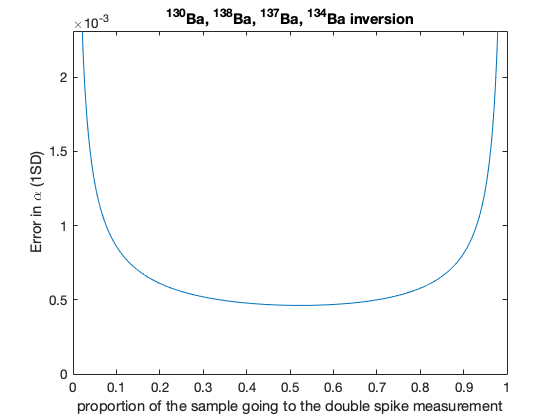

In [8]:
element='Ba';
prop=0.5;
spike=[0.09115 0.002403 0.008985 0.016012 0.01826 0.6359 0.227291]; % 130-137 spike
isoinv=[130 138 137 134];
INisos=[138 134];

errorcurve3(element,prop,spike,isoinv,INisos)

#### Example 4.2 

An additional feature in `errorcurve3.m` is the ability to plot the uncertainties on the unspiked measurements in terms of the error in $\varepsilon$ units (parts per $10^4$ deviation for the standard after internal normalization) for a given set of isotopes specified by the user. Here we choose to plot the uncertainties on $\varepsilon^{130}Ba$, $\varepsilon^{135}Ba$, and $\varepsilon^{138}Ba$ by entering the array `epsisos` as an input.

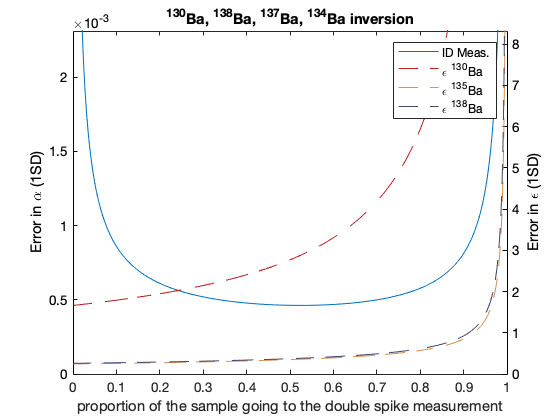

In [9]:
epsisos=[130 135 138]; % Mass numbers for isotopes of interest

errorcurve3(element,prop,spike,isoinv,INisos,epsisos)

#### Example 4.3 

Here, we simply plot an error surface that explores the uncertainty in $\alpha$ as a function of both the spiking proportion ($p$) and the sample splitting ($S$).

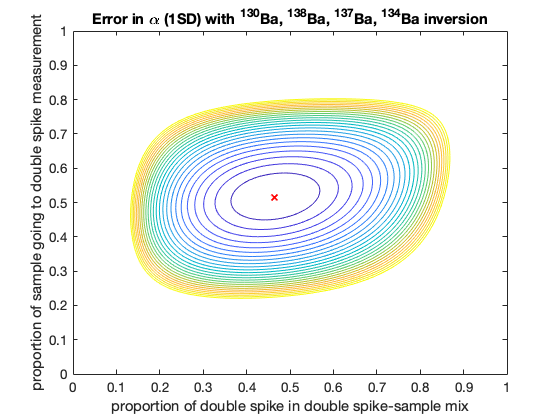

In [10]:
errorsurface('Ba',spike,isoinv,INisos)

### 5. `cosmo.m` : A different kind of cocktail list

The namesake function of the software suite, `cosmo.m`, is our version of the original `cocktail.m` function that allows the user to get a list of optimal spike combinations. With this function however, the optimization is implemeneted with our error model of a fixed sample split between spiked and unspiked measurements, and with the uncertainties of the latter internally-normalized and always propagated to the final $\sigma_{\alpha}$. 

Note that since `calcratiocovIN.m` only works with real spikes (*i.e.,* spikes where each isotope is present -  thus Ab $\neq$ 0), all dependent functions including `cosmo.m` only perform calculations/optimizations with these real spikes. 

In [11]:
cosmo('cosmo_example.csv',{'Ba'})

Writing to cosmo_example.csv
Ba


In [12]:
cosmo_example = readtable('cosmo_example.csv');
disp(head(cosmo_example,10))

     iso1       iso2       iso3       iso4       Ba130       Ba132       Ba134       Ba135       Ba136       Ba137       Ba138     spike1     spike2     spike3     spike4     spike5     spike6    spike7     spike     sample      split      error      ppmperamu    normnum    normden
    _______    _______    _______    _______    ________    ________    ________    ________    ________    ________    _______    _______    _______    _______    _______    _______    ______    ______    _______    _______    _______    ________    _________    _______    _______

    'Ba130'    'Ba135'    'Ba136'    'Ba138'      0.3048    0.007312    0.029001    0.053088     0.22123    0.056192    0.32837    0.81037          0          0          0    0.18963      0         0       0.27778    0.72222    0.58897    0.000315     2.3392      'Ba138'    'Ba136'
    'Ba130'    'Ba134'    'Ba135'    'Ba138'     0.31955    0.007732    0.030946     0.19405    0.049874    0.056732    0.34111     0.8496          0 